In [17]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [18]:
folder_nonlinear = './results_non_linear_vm1'

csv_file_nonlinear = 'nonlinear_results_summary.csv'

figures_folder = './figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)


In [19]:
# Define a function to process a single file
def process_file(filepath):
    with open(filepath, 'r') as f:
        try:
            data = json.load(f)
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
            raise e
    
    # Extract columns, using placeholders for missing data
    scenario_name = data.get("model_file", "-").replace('.json', '')
    algorithm = data.get("configuration", {}).get("algorithm", "-")
    size = data.get("configuration", {}).get("size", "-")
    optimizer = data.get("configuration", {}).get("optimizer", "-")
    annealings = data.get("configuration", {}).get("nonlinear_annealings", "-")
    iterations = data.get("configuration", {}).get("nonlinear_iterations", "-")

    reasoner = data.get("reasoner_results", {})
    if isinstance(reasoner, str):
        print(f"File {filepath} has reasoner results as a string, converting to dict.")
        reasoner = {"status": reasoner}
    status = reasoner.get("status", "-")
    score = reasoner.get("score", "-")
    evaluation = reasoner.get("evaluation", "-")
    exec_time = reasoner.get("solver_exec_time", "-")
    total_cost = reasoner.get("total_cost", "-")
    max_time = reasoner.get("max_time", "-")
    min_fidelity = reasoner.get("min_fidelity", "-")
    dispatch = reasoner.get("dispatch", {})

    if scenario_name == "scenario2":
        evaluation = -evaluation

    if  optimizer == "nonlinear":
        baseline = "qb-nonlinear"
    else:
        raise ValueError("This function is for nonlinear optimizer results only.")
    # Row for DataFrame
    row = {
        #"baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        #"optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        #"score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        #"total_cost": total_cost,
        #"max_time": max_time,
        #"min_fidelity": min_fidelity
    }
    
    # Key for dispatches dict
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    
    return row, dispatch_key, dispatch

In [20]:
data_rows = []
dispatches = {}

if os.path.exists(csv_file_nonlinear):
    df = pd.read_csv(csv_file_nonlinear)    
else:
    base_files = [os.path.join(folder_nonlinear, f) for f in os.listdir(folder_nonlinear) if f.endswith('.json')]
    for file in base_files:
        row, key, dispatch = process_file(file)
        data_rows.append(row)
        dispatches[key] = dispatch

    # Create DataFrame
    df = pd.DataFrame(data_rows)
    df.to_csv(csv_file_nonlinear, index=False)

# Show results
print("DataFrame:")
df['algorithm'] = df['algorithm'].replace('realamprandom', 'realamprnd')
df['algorithm'] = df['algorithm'].replace('twolocalrandom', 'twolocalrnd')
display(df)

#print("\nDispatches dictionary (keys and values):")
#for k, v in dispatches.items():
#    print(f"{k}: {v}")



DataFrame:


,scenario_name,algorithm,size,annealings,iterations,status,evaluation,exec_time
0,scenario3,qft,6,30,55,solution_found,194.850000,59.585742
1,scenario3,vqe,8,20,1,solution_found,207.760000,1.566152
2,scenario2,qaoa,6,20,30,solution_found,670.764271,34.758863
3,scenario2,twolocalrnd,8,15,1,solution_found,238.743291,1.439434
4,scenario1,qnn,8,1,50,solution_found,276.844177,3.454640
...,...,...,...,...,...,...,...,...
5728,scenario2,twolocalrnd,6,25,45,solution_found,253.834904,57.994005
5729,scenario3,qnn,8,1,1,solution_found,292.880000,0.157777
5730,scenario1,twolocalrnd,6,30,60,solution_found,199.990208,102.633773
5731,scenario3,qaoa,10,30,15,solution_found,435.400000,21.930080


In [21]:
df.columns



Index(['scenario_name', 'algorithm', 'size', 'annealings', 'iterations',
       'status', 'evaluation', 'exec_time'],
      dtype='object')

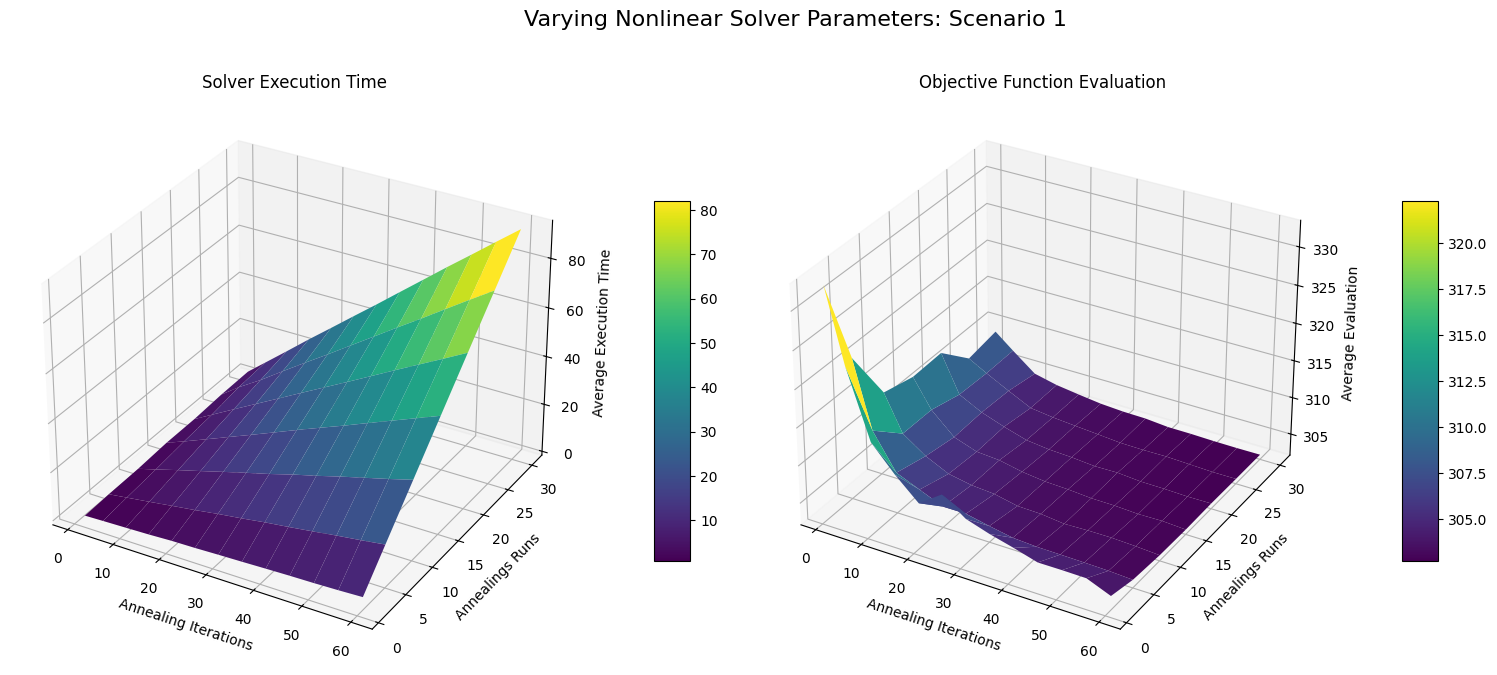

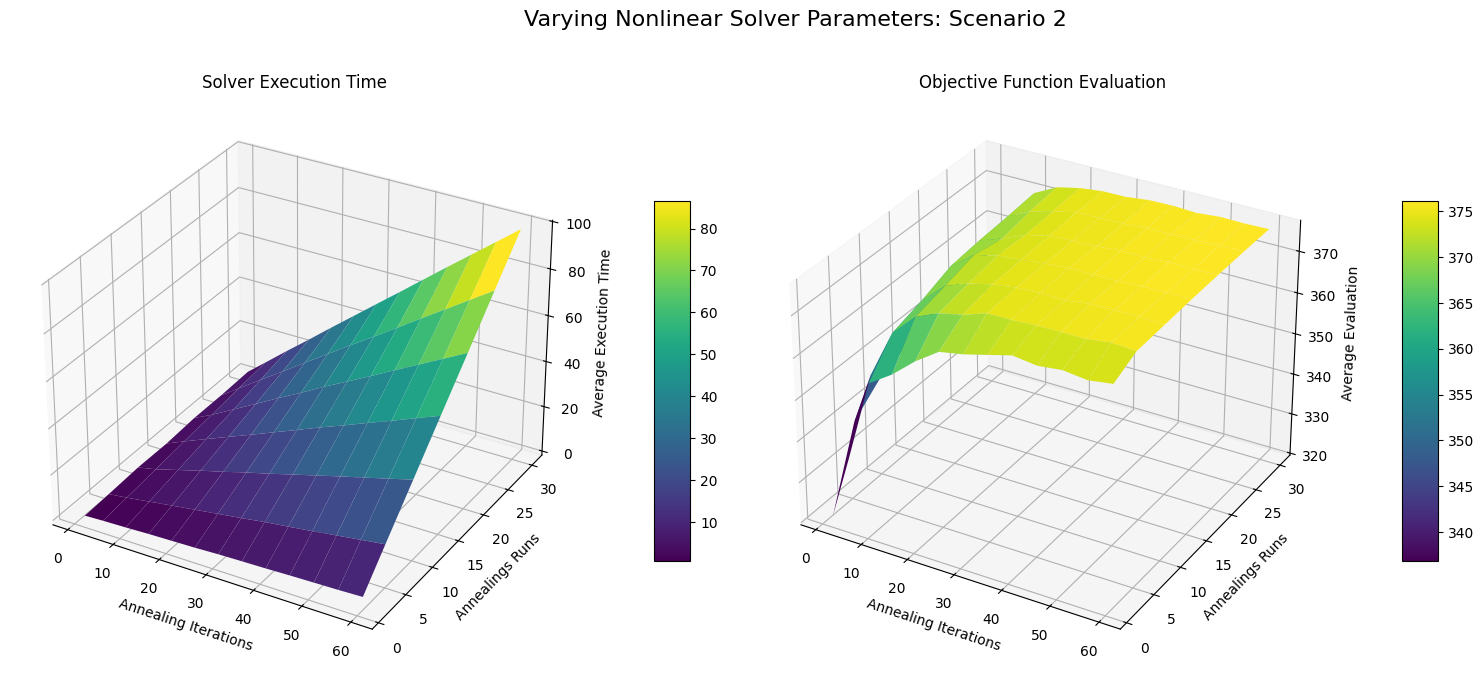

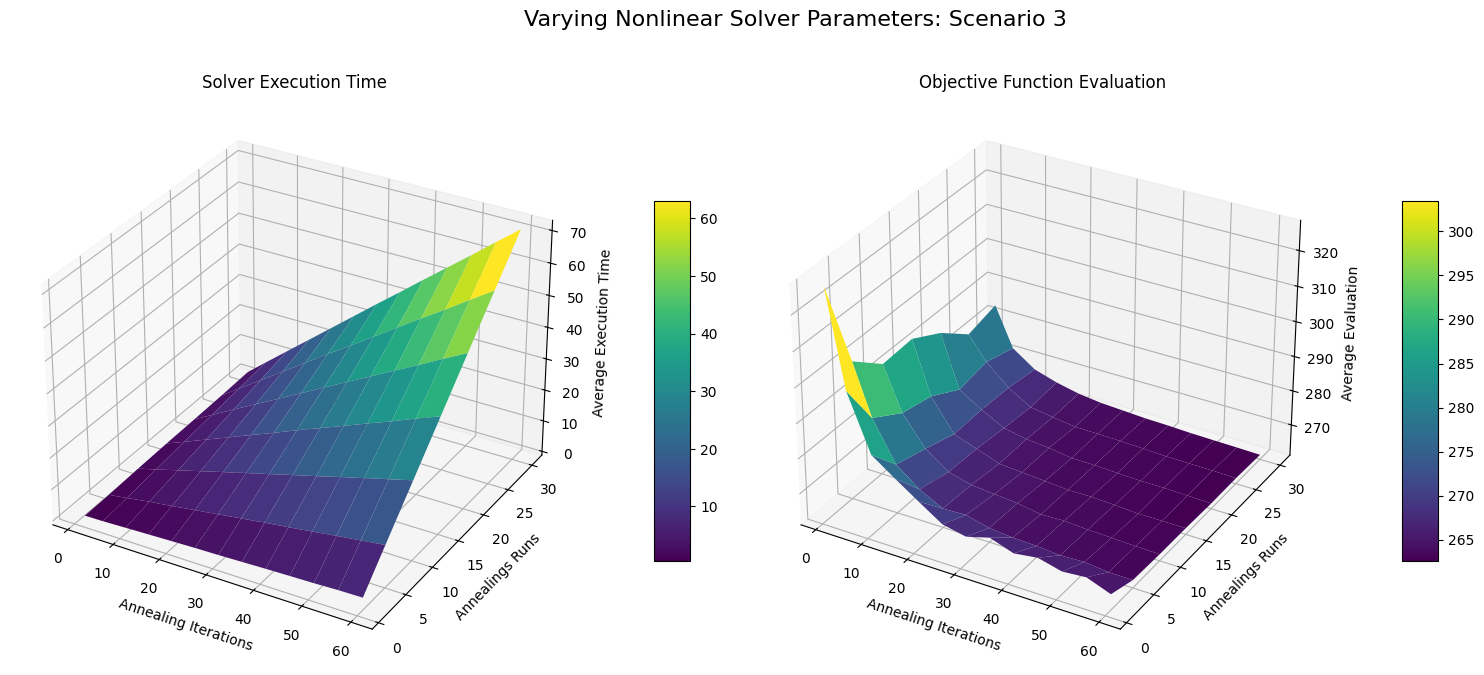

In [22]:
# Group by scenario_name, iterations, annealings and compute mean exec_time
df_grouped = df.groupby(
    ['scenario_name', 'iterations', 'annealings']
)['exec_time'].mean().reset_index()

df_grouped2 = df.groupby(
    ['scenario_name', 'iterations', 'annealings']
)['evaluation'].mean().reset_index()

#fig, axes = plt.subplots(1, 2, figsize=(12, 12), sharey=True)


for scenario in df_grouped['scenario_name'].unique():
    plt.close('all')  # Ensure no leftovers
    fig = plt.figure(figsize=(16, 7))
    fig.suptitle(f"Varying Nonlinear Solver Parameters: Scenario {scenario[-1]}", fontsize=16)

    # First plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    sub_df1 = df_grouped[df_grouped['scenario_name'] == scenario]
    pivot1 = sub_df1.pivot_table(index='iterations', columns='annealings', values='exec_time')
    X1, Y1 = np.meshgrid(pivot1.index, pivot1.columns)
    Z1 = pivot1.values.T
    surf1 = ax1.plot_surface(X1, Y1, Z1, cmap='viridis')
    ax1.set_title('Solver Execution Time')
    ax1.set_xlabel('Annealing Iterations')
    ax1.set_ylabel('Annealings Runs')
    ax1.set_zlabel('Average Execution Time')
    fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10, pad=0.1)

    # Second plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    sub_df2 = df_grouped2[df_grouped2['scenario_name'] == scenario]
    pivot2 = sub_df2.pivot_table(index='iterations', columns='annealings', values='evaluation')
    X2, Y2 = np.meshgrid(pivot2.index, pivot2.columns)
    Z2 = pivot2.values.T
    surf2 = ax2.plot_surface(X2, Y2, Z2, cmap='viridis')
    ax2.set_title('Objective Function Evaluation')
    ax2.set_xlabel('Annealing Iterations')
    ax2.set_ylabel('Annealings Runs')
    ax2.set_zlabel('Average Evaluation')
    fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10, pad=0.1)

    plt.tight_layout(rect=[0, 0, 0.96, 0.95])
    plt.savefig(f'{figures_folder}/{scenario}_nonlinear_analysis.pdf', format="pdf", bbox_inches='tight')
    plt.show()
